# Fuzzy Demand Classification & Scheduling
## **Problem statement:** How can household energy consumption be classified into low, medium, and high demand levels to enable cost optimization?

> **Goal:** How can household energy consumption patterns be classified into Low, Medium, and High demand levels in a way that reflects both temporal usage variations and dynamic electricity pricing, so that fuzzy logic–based scheduling can enable cost optimization and reduce peak demand?


#### Load data - house 1

In [145]:
import pandas as pd

# Load your dataset
file_path = "./data/house1_2013_1min-kopi.csv"
data = pd.read_csv(file_path, parse_dates=["timestamp"], index_col="timestamp")

# column metadata - categories
data.attrs["categories"] = {
    "kitchen": ["dishwasher", "kettle", "toaster", "microwave"],
    "livingroom": ["tv", "htpc", "amp_livingroom", "subwoofer_livingroom"],
    "lights": [ "kitchen_lights", "livingroom_s_lamp", "kitchen_dt_lamp", "bedroom_ds_lamp", "livingroom_s_lamp2", "livingroom_lamp_tv", "kitchen_lamp2", "utility_lamp", "bedroom_d_lamp", "childs_table_lamp", "childs_ds_lamp", "office_lamp1", "office_lamp2", "office_lamp3" ],
    "washing_machine": ["washing_machine"]
}

data


,aggregate,washing_machine,dishwasher,tv,kitchen_lights,htpc,kettle,toaster,microwave,amp_livingroom,...,subwoofer_livingroom,livingroom_lamp_tv,kitchen_lamp2,utilityrm_lamp,bedroom_d_lamp,childs_table_lamp,childs_ds_lamp,office_lamp1,office_lamp2,office_lamp3
timestamp,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,507.800,0.0,1.0,94.000,0.0,69.200,1.0,0.0,1.0,23.200,...,0.000,0.5,0.000,28.0,0.0,0.0,0.0,14.0,10.0,7.000
2013-01-01 00:01:00,525.100,0.0,1.0,108.100,0.0,69.400,1.0,0.0,1.0,23.100,...,0.000,0.5,0.000,28.0,0.0,0.0,0.0,14.0,10.0,7.000
2013-01-01 00:02:00,519.500,0.0,1.0,101.556,0.0,69.444,1.0,0.0,1.0,23.111,...,0.000,0.5,0.000,28.0,0.0,0.0,0.0,14.0,10.0,7.000
2013-01-01 00:03:00,512.667,0.0,1.0,97.900,0.0,69.700,1.0,0.0,1.0,23.000,...,0.000,0.5,0.000,28.0,0.0,0.0,0.0,14.0,10.0,7.000
2013-01-01 00:04:00,512.300,0.0,1.0,91.900,0.0,69.200,1.0,0.0,1.0,23.200,...,0.000,0.5,0.000,28.0,0.0,0.0,0.0,14.0,10.0,7.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 23:55:00,396.800,0.0,1.0,1.000,0.0,64.667,1.0,1.0,1.0,23.444,...,17.333,13.0,18.000,0.0,0.0,0.0,0.0,0.0,0.0,6.875
2013-12-31 23:56:00,394.800,0.0,1.0,1.000,0.0,67.250,1.0,1.0,1.0,23.250,...,17.333,13.0,18.111,0.0,0.0,0.0,0.0,0.0,0.0,6.875
2013-12-31 23:57:00,393.700,0.0,1.0,1.000,0.0,64.625,1.0,1.0,1.0,23.000,...,17.857,13.0,18.000,0.0,0.0,0.0,0.0,0.0,0.0,6.875


### Define universal fuzzy memebership functions

In [126]:
!pip install scikit-fuzzy


[notice] A new release of pip is available: 24.3.1 -> 25.2
[notice] To update, run: python3.11 -m pip install --upgrade pip


In [146]:
import numpy as np
import skfuzzy as fuzz

# Define power range
x_power = np.arange(0, 4001, 1)

# Universal fuzzy sets
mf_off = fuzz.trimf(x_power, [0, 0, 10])         # near 0W
mf_low = fuzz.trimf(x_power, [0, 50, 200])       # small standby or dim usage
mf_med = fuzz.trimf(x_power, [150, 800, 1500])   # mid-range power
mf_high = fuzz.trimf(x_power, [1000, 4000, 4000]) # high consumption


# apply to each appliance col
appliance_cols = [col for col in data.columns if col != "aggregate"]

def fuzzify_absolute(series):
    """

    :param series:
    :return:
    """
    off = fuzz.interp_membership(x_power, mf_off, series)
    low = fuzz.interp_membership(x_power, mf_low, series)
    med = fuzz.interp_membership(x_power, mf_med, series)
    high = fuzz.interp_membership(x_power, mf_high, series)
    return pd.DataFrame({
        f"{series.name}_off": off,
        f"{series.name}_low": low,
        f"{series.name}_medium": med,
        f"{series.name}_high": high
    }, index=series.index)

fuzzy_frames = [fuzzify_absolute(data[col]) for col in appliance_cols]
fuzzy_data = pd.concat(fuzzy_frames, axis=1)

fuzzy_data

,washing_machine_off,washing_machine_low,washing_machine_medium,washing_machine_high,dishwasher_off,dishwasher_low,dishwasher_medium,dishwasher_high,tv_off,tv_low,...,office_lamp1_medium,office_lamp1_high,office_lamp2_off,office_lamp2_low,office_lamp2_medium,office_lamp2_high,office_lamp3_off,office_lamp3_low,office_lamp3_medium,office_lamp3_high
timestamp,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,1.0,0.0,0.0,0.0,0.9,0.02,0.0,0.0,0.0,0.706667,...,0.0,0.0,0.0,0.2,0.0,0.0,0.3000,0.1400,0.0,0.0
2013-01-01 00:01:00,1.0,0.0,0.0,0.0,0.9,0.02,0.0,0.0,0.0,0.612667,...,0.0,0.0,0.0,0.2,0.0,0.0,0.3000,0.1400,0.0,0.0
2013-01-01 00:02:00,1.0,0.0,0.0,0.0,0.9,0.02,0.0,0.0,0.0,0.656293,...,0.0,0.0,0.0,0.2,0.0,0.0,0.3000,0.1400,0.0,0.0
2013-01-01 00:03:00,1.0,0.0,0.0,0.0,0.9,0.02,0.0,0.0,0.0,0.680667,...,0.0,0.0,0.0,0.2,0.0,0.0,0.3000,0.1400,0.0,0.0
2013-01-01 00:04:00,1.0,0.0,0.0,0.0,0.9,0.02,0.0,0.0,0.0,0.720667,...,0.0,0.0,0.0,0.2,0.0,0.0,0.3000,0.1400,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 23:55:00,1.0,0.0,0.0,0.0,0.9,0.02,0.0,0.0,0.9,0.020000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.3125,0.1375,0.0,0.0
2013-12-31 23:56:00,1.0,0.0,0.0,0.0,0.9,0.02,0.0,0.0,0.9,0.020000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.3125,0.1375,0.0,0.0
2013-12-31 23:57:00,1.0,0.0,0.0,0.0,0.9,0.02,0.0,0.0,0.9,0.020000,...,0.0,0.0,1.0,0.0,0.0,0.0,0.3125,0.1375,0.0,0.0


In [137]:
# check fuzzy degree distributions
fuzzy_data.describe().T[['mean', 'min', 'max']]

,mean,min,max
washing_machine_off,9.477351e-01,0.0,1.000000
washing_machine_low,1.623063e-02,0.0,1.000000
washing_machine_medium,3.430246e-03,0.0,0.999366
washing_machine_high,2.445039e-03,0.0,0.415444
dishwasher_off,8.934495e-01,0.0,1.000000
...,...,...,...
office_lamp2_high,0.000000e+00,0.0,0.000000
office_lamp3_off,6.125773e-01,0.0,1.000000
office_lamp3_low,7.748826e-02,0.0,0.934813
office_lamp3_medium,6.907856e-07,0.0,0.363077


### Join with electricity prices

In [129]:
### Join with electricity prices (robust)

import pandas as pd
import numpy as np

# --- Ensure fuzzy_data has a 'timestamp' column (not just index)
if 'timestamp' not in fuzzy_data.columns:
    fuzzy_data = fuzzy_data.reset_index()
    if 'index' in fuzzy_data.columns and 'timestamp' not in fuzzy_data.columns:
        fuzzy_data = fuzzy_data.rename(columns={'index': 'timestamp'})

# --- Load hourly prices and standardize columns
el_price_all = pd.read_csv("./data/spotpriser_2024.csv", parse_dates=["timestamp"])
el_price = el_price_all.rename(columns={"NO1": "el_price"})[["timestamp", "el_price"]]

# --- Parse timestamps (coerce errors to NaT)
fuzzy_data['timestamp'] = pd.to_datetime(fuzzy_data['timestamp'], errors='coerce')
el_price['timestamp']   = pd.to_datetime(el_price['timestamp'],   errors='coerce')

# (Optional) Align timezones if one is tz-aware and the other is naive:
# if hasattr(fuzzy_data['timestamp'].dtype, 'tz') and fuzzy_data['timestamp'].dt.tz is not None:
#     el_price['timestamp'] = el_price['timestamp'].dt.tz_localize('Europe/Oslo')  # example
#     el_price['timestamp'] = el_price['timestamp'].dt.tz_convert(fuzzy_data['timestamp'].dt.tz)

# --- Drop rows where timestamp failed to parse (NaT)
fuzzy_data = fuzzy_data.dropna(subset=['timestamp'])
el_price   = el_price.dropna(subset=['timestamp'])

# --- Floor to full hour using modern aliases (no FutureWarning)
fuzzy_data['ts_hour'] = fuzzy_data['timestamp'].dt.floor('1h')
el_price['ts_hour']   = el_price['timestamp'].dt.floor('1h')

# --- Deduplicate price hours (keep first)
hourly_prices = el_price[['ts_hour', 'el_price']].drop_duplicates(subset='ts_hour', keep='first')

# --- Final clean before merge: drop any NaT in keys and sort
fuzzy_data = fuzzy_data.dropna(subset=['ts_hour']).sort_values('ts_hour')
hourly_prices = hourly_prices.dropna(subset=['ts_hour']).sort_values('ts_hour')

# --- Merge by full hourly timestamp; limit match to within 1 hour
merged = pd.merge_asof(
    left=fuzzy_data,
    right=hourly_prices,
    on='ts_hour',
    direction='backward',
    tolerance=pd.Timedelta('1h')  # ensures we only pull the current hour's price
)

# --- (Optional) report rows that still lack a price (e.g., outside price coverage)
missing_prices = merged['el_price'].isna().sum()
if missing_prices:
    print(f"Note: {missing_prices} rows have no matching hourly price (outside price coverage).")

# --- Clean up helper column if you don’t need it
merged = merged.drop(columns=['ts_hour'])
merged


Note: 525600 rows have no matching hourly price (outside price coverage).


,timestamp,washing_machine_off,washing_machine_low,washing_machine_medium,washing_machine_high,dishwasher_off,dishwasher_low,dishwasher_medium,dishwasher_high,tv_off,...,office_lamp1_high,office_lamp2_off,office_lamp2_low,office_lamp2_medium,office_lamp2_high,office_lamp3_off,office_lamp3_low,office_lamp3_medium,office_lamp3_high,el_price
0,2013-01-01 00:00:00,1.0,0.0,0.0,0.0,0.9,0.02,0.0,0.0,0.00,...,0.0,0.0,0.2,0.0,0.0,0.3000,0.1400,0.0,0.0,NaN
1,2013-01-01 00:32:00,1.0,0.0,0.0,0.0,0.9,0.02,0.0,0.0,0.00,...,0.0,0.0,0.2,0.0,0.0,0.3000,0.1400,0.0,0.0,NaN
2,2013-01-01 00:33:00,1.0,0.0,0.0,0.0,0.9,0.02,0.0,0.0,0.00,...,0.0,0.0,0.2,0.0,0.0,0.3000,0.1400,0.0,0.0,NaN
3,2013-01-01 00:34:00,1.0,0.0,0.0,0.0,0.9,0.02,0.0,0.0,0.91,...,0.0,0.0,0.2,0.0,0.0,0.3000,0.1400,0.0,0.0,NaN
4,2013-01-01 00:35:00,1.0,0.0,0.0,0.0,0.9,0.02,0.0,0.0,0.90,...,0.0,0.0,0.2,0.0,0.0,0.3000,0.1400,0.0,0.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525595,2013-12-31 23:24:00,1.0,0.0,0.0,0.0,0.9,0.02,0.0,0.0,0.90,...,0.0,1.0,0.0,0.0,0.0,0.3125,0.1375,0.0,0.0,NaN
525596,2013-12-31 23:25:00,1.0,0.0,0.0,0.0,0.9,0.02,0.0,0.0,0.90,...,0.0,1.0,0.0,0.0,0.0,0.3125,0.1375,0.0,0.0,NaN
525597,2013-12-31 23:26:00,1.0,0.0,0.0,0.0,0.9,0.02,0.0,0.0,0.90,...,0.0,1.0,0.0,0.0,0.0,0.3125,0.1375,0.0,0.0,NaN
525598,2013-12-31 23:28:00,1.0,0.0,0.0,0.0,0.9,0.02,0.0,0.0,0.90,...,0.0,1.0,0.0,0.0,0.0,0.3125,0.1375,0.0,0.0,NaN


In [130]:
print("Timestamp summary:")
print(f"  Start: {data.index.min()}")
print(f"  End:   {data.index.max()}")
print(f"  Count: {len(data)} rows")

Timestamp summary:
  Start: 2013-01-01 00:00:00
  End:   2013-12-31 23:59:00
  Count: 525600 rows


In [131]:
import pandas as pd

# Ensure the index is a proper DatetimeIndex
if not isinstance(data.index, pd.DatetimeIndex):
    data.index = pd.to_datetime(data.index, errors='coerce')

# Drop any rows that couldn’t be parsed (NaT)
data = data[~data.index.isna()]

# Count timestamps per day
ts_per_day = data.index.to_series().dt.floor('D').value_counts().sort_index()

print("Timestamps per day:")
print(ts_per_day.head())

print(f"\nAverage per day: {ts_per_day.mean():.1f}")

Timestamps per day:
timestamp
2013-01-01    1440
2013-01-02    1440
2013-01-03    1440
2013-01-04    1440
2013-01-05    1440
Name: count, dtype: int64

Average per day: 1440.0


In [132]:
ts_per_hour = data.index.floor('h').value_counts().sort_index()
print("Timestamps per hour (first few):")
print(ts_per_hour.head(24))


Timestamps per hour (first few):
timestamp
2013-01-01 00:00:00    60
2013-01-01 01:00:00    60
2013-01-01 02:00:00    60
2013-01-01 03:00:00    60
2013-01-01 04:00:00    60
2013-01-01 05:00:00    60
2013-01-01 06:00:00    60
2013-01-01 07:00:00    60
2013-01-01 08:00:00    60
2013-01-01 09:00:00    60
2013-01-01 10:00:00    60
2013-01-01 11:00:00    60
2013-01-01 12:00:00    60
2013-01-01 13:00:00    60
2013-01-01 14:00:00    60
2013-01-01 15:00:00    60
2013-01-01 16:00:00    60
2013-01-01 17:00:00    60
2013-01-01 18:00:00    60
2013-01-01 19:00:00    60
2013-01-01 20:00:00    60
2013-01-01 21:00:00    60
2013-01-01 22:00:00    60
2013-01-01 23:00:00    60
Name: count, dtype: int64


In [133]:
summary = {
    "1min":   len(data.resample("1min")),
    "15min":  len(data.resample("15min")),
    "1hour":  len(data.resample("1h")),
    "1day":   len(data.resample("1d"))
}

print("Timestamp counts by aggregation level (number of bins):")
for k, v in summary.items():
    print(f"  {k:6}: {v:,}")


Timestamp counts by aggregation level (number of bins):
  1min  : 525,600
  15min : 35,040
  1hour : 8,760
  1day  : 365


## Comparable datasets at 1min, 15min, and 1h

In [134]:
import pandas as pd

# Use whichever DataFrame exists: 'd' (processed) or fallback to 'data'
source = globals().get("d", None)
if source is None:
    source = data  # fallback to your loaded dataset

# pick the day you want to show (default = first day in dataset)
day = pd.Timestamp(source.index[0].date())  # or pd.Timestamp("2013-01-01")

# choose appliances to include (or leave empty [])
#selected_appliances = ["dishwasher", "washing_machine", "tv"]


# List all appliance columns available
appliance_candidates = [col for col in source.columns if col not in ["aggregate", "smart_aggregate"]]
print("\nAvailable appliance columns:")
print(", ".join(appliance_candidates))

# Let the user type appliance names after running the cell
selected_appliances = input("\nType appliances separated by commas (or press Enter for none): ")


# --- Parse and validate the typed appliances ---
typed = [a.strip() for a in selected_appliances.split(",") if a.strip()]  # turn into list

# exact candidates available in the data (excluding aggregates)
appliance_candidates = [c for c in source.columns if c not in ["aggregate", "smart_aggregate"]]

# keep only those that actually exist
selected_appliances = [a for a in typed if a in appliance_candidates]

# report mismatches (helps catch typos like 'utilityrm_lamp' vs 'utility_lamp')
missing = [a for a in typed if a not in appliance_candidates]
if missing:
    print(" Not found (ignored):", ", ".join(missing))
print("Using appliances:", ", ".join(selected_appliances) if selected_appliances else "None")


# also include grouped categories (if defined in data.attrs)
include_groups = True



Available appliance columns:
washing_machine, dishwasher, tv, kitchen_lights, htpc, kettle, toaster, microwave, amp_livingroom, livingroom_s_lamp, kitchen_dt_lamp, bedroom_ds_lamp, livingroom_s_lamp2, subwoofer_livingroom, livingroom_lamp_tv, kitchen_lamp2, utilityrm_lamp, bedroom_d_lamp, childs_table_lamp, childs_ds_lamp, office_lamp1, office_lamp2, office_lamp3


KeyboardInterrupt: Interrupted by user

In [102]:
# --- build the metric dictionary: aggregate (baseline + smart) + chosen appliances
metrics = {}

# aggregate series
if "aggregate" in source.columns:
    metrics["Aggregate (Baseline)"] = source["aggregate"].copy()
if "smart_aggregate" in source.columns:
    metrics["Aggregate (Smart)"] = source["smart_aggregate"].copy()

# appliance series
for col in selected_appliances:
    if col in source.columns:
        metrics[f"{col}"] = source[col].copy()

# optional category group sums (e.g., kitchen, livingroom, lights, other)
if include_groups and hasattr(source, "attrs") and "categories" in source.attrs:
    for group, cols in source.attrs["categories"].items():
        cols = [c for c in cols if c in source.columns]
        if cols:
            metrics[f"{group}_sum"] = source[cols].sum(axis=1)

# --- slice the chosen day at native 1-minute grid
start = day.normalize()
end = start + pd.Timedelta(days=1)
metrics_day = {name: s.loc[start:end].asfreq("1min") for name, s in metrics.items()}

# --- resample helper
def resample_levels(series_dict, freq: str):
    """Return a dict of DataFrames resampled to freq with mean power."""
    out = {}
    for name, s in series_dict.items():
        out[name] = s.resample(freq).mean()
    return out

one_min   = metrics_day                          # 1-min (no averaging; on a 1-min grid)
fifteen_m = resample_levels(metrics_day, "15min")
one_hour  = resample_levels(metrics_day, "1h")

# --- tidy (long) formatter for any dict of series
def to_tidy(series_dict, granularity: str):
    frames = []
    for name, s in series_dict.items():
        df = s.to_frame(name="value").reset_index().rename(columns={"index":"timestamp"})
        df["metric"] = name
        df["granularity"] = granularity
        frames.append(df)
    return pd.concat(frames, ignore_index=True) if frames else pd.DataFrame(columns=["timestamp","value","metric","granularity"])

tidy_1min  = to_tidy(one_min,   "1min")
tidy_15min = to_tidy(fifteen_m, "15min")
tidy_1h    = to_tidy(one_hour,  "1h")

# combined tidy table for the day (for plotting or CSV export)
tidy_all = pd.concat([tidy_1min, tidy_15min, tidy_1h], ignore_index=True)

# ensure ordering and types
tidy_all = tidy_all.sort_values(["granularity","metric","timestamp"]).reset_index(drop=True)

tidy_all.to_csv("./baseline_smart_and_appliances_by_granularity.csv", index=False)

# Also provide wide tables (columns per metric) if they prefer that style:
def to_wide(series_dict, freq_label):
    df = pd.concat(series_dict.values(), axis=1)
    df.columns = list(series_dict.keys())
    df = df.reset_index().rename(columns={"index":"timestamp"})
    df["granularity"] = freq_label
    return df

wide_1min  = to_wide(one_min,   "1min")
wide_15min = to_wide(fifteen_m, "15min")
wide_1h    = to_wide(one_hour,  "1h")

# The three outputs to choose from:
# - tidy_1min / tidy_15min / tidy_1h (long format)
# - tidy_all (all granularities together)
# - wide_1min / wide_15min / wide_1h (wide format)


In [103]:
from difflib import get_close_matches

# Parse the input into a clean list (handles single string from input())
if isinstance(selected_appliances, str):
    selected_list = [a.strip() for a in selected_appliances.split(",") if a.strip()]
else:
    selected_list = [str(a).strip() for a in selected_appliances]


appliance_data = tidy_all[ tidy_all['metric'].isin(selected_list) ].copy()

print(appliance_data['granularity'].value_counts())
print(appliance_data['granularity'].unique())

granularity
1min     1441
15min      97
1h         25
Name: count, dtype: int64
['15min' '1h' '1min']


In [104]:
# --- Show only the selected appliances from tidy_all ---

if isinstance(selected_appliances, str):
    # if you only typed one name (not a list)
    selected_appliances = [a.strip() for a in selected_appliances.split(",") if a.strip()]

# Filter the tidy table for the selected appliances
appliance_data = tidy_all[tidy_all["metric"].isin(selected_appliances)].copy()

print(f"Showing data for: {selected_appliances}")
display(appliance_data.head(20))  # show first 20 rows


Showing data for: ['kettle']


,timestamp,value,metric,granularity
97,2013-01-01 00:00:00,1.000000,kettle,15min
98,2013-01-01 00:15:00,1.000000,kettle,15min
99,2013-01-01 00:30:00,1.000000,kettle,15min
100,2013-01-01 00:45:00,1.000000,kettle,15min
101,2013-01-01 01:00:00,1.000000,kettle,15min
102,2013-01-01 01:15:00,1.000000,kettle,15min
103,2013-01-01 01:30:00,1.000000,kettle,15min
104,2013-01-01 01:45:00,1.000000,kettle,15min
105,2013-01-01 02:00:00,1.000000,kettle,15min
106,2013-01-01 02:15:00,1.000000,kettle,15min


## Visualising the Data

In [177]:
import matplotlib.pyplot as plt
import seaborn as sns

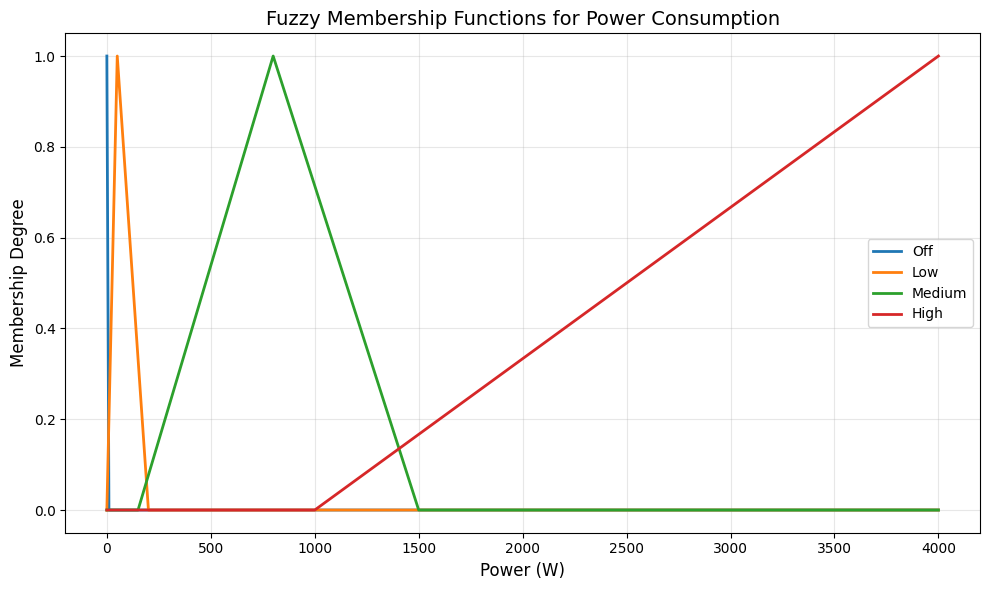

In [139]:
# Visualize the fuzzy membership functions

plt.figure(figsize=(10, 6))
plt.plot(x_power, mf_off, label='Off', linewidth=2)
plt.plot(x_power, mf_low, label='Low', linewidth=2)
plt.plot(x_power, mf_med, label='Medium', linewidth=2)
plt.plot(x_power, mf_high, label='High', linewidth=2)


plt.title('Fuzzy Membership Functions for Power Consumption', fontsize=14)
plt.xlabel('Power (W)', fontsize=12)
plt.ylabel('Membership Degree', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


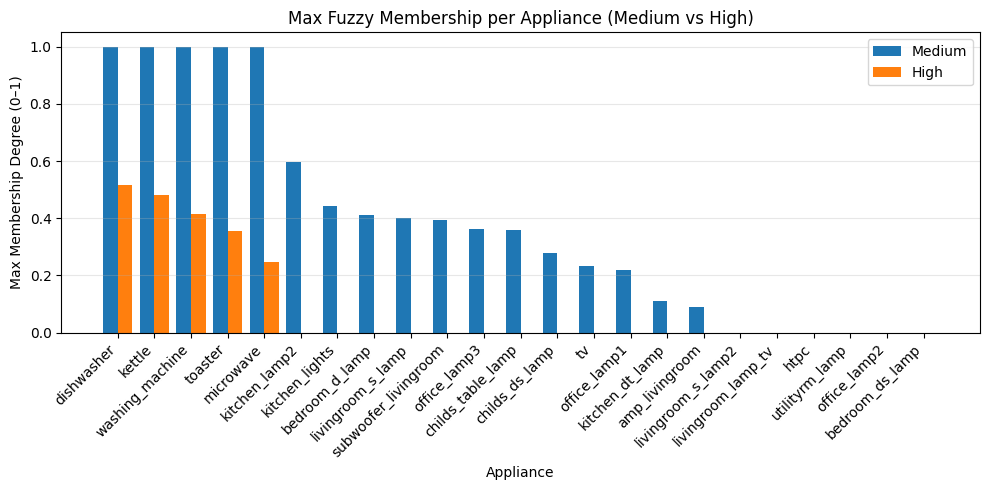

In [140]:
# Compute max fuzzy membership per appliance for medium and high
fuzzy_summary = pd.DataFrame({
    'Medium': [fuzzy_data[c].max() for c in fuzzy_data.columns if c.endswith('_medium')],
    'High':   [fuzzy_data[c].max() for c in fuzzy_data.columns if c.endswith('_high')]
}, index=[c.replace('_medium', '').replace('_high', '') for c in fuzzy_data.columns if c.endswith('_medium')])

# Sort by total max membership
fuzzy_summary['Total'] = fuzzy_summary['Medium'] + fuzzy_summary['High']
fuzzy_summary = fuzzy_summary.sort_values('Total', ascending=False)

# Plot side-by-side bars
x = np.arange(len(fuzzy_summary))
width = 0.4

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - width/2, fuzzy_summary['Medium'], width, label='Medium')
ax.bar(x + width/2, fuzzy_summary['High'], width, label='High')

ax.set_xticks(x)
ax.set_xticklabels(fuzzy_summary.index, rotation=45, ha='right')
ax.set_ylabel("Max Membership Degree (0–1)")
ax.set_xlabel("Appliance")
ax.set_title("Max Fuzzy Membership per Appliance (Medium vs High)")
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


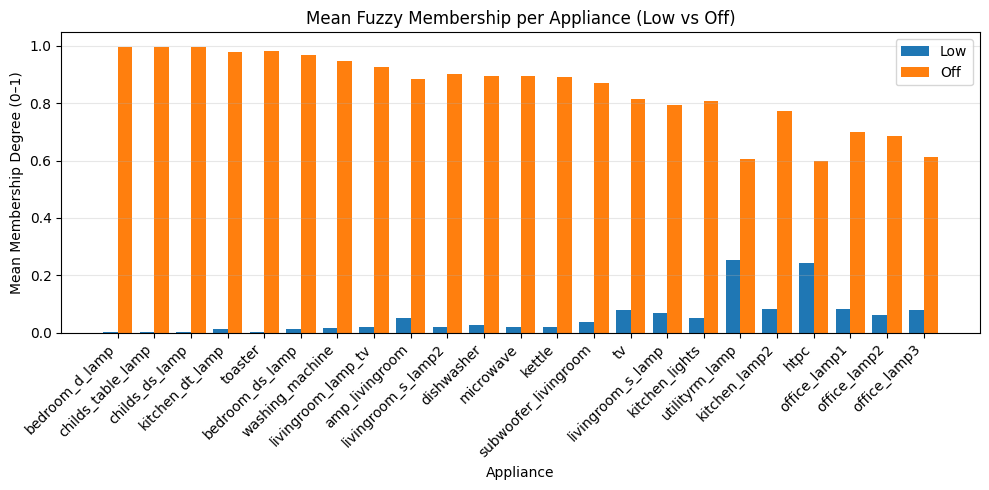

In [141]:
# Compute max fuzzy membership per appliance for 'low' and 'off'
fuzzy_summary_low_off = pd.DataFrame({
    'Low': [fuzzy_data[c].mean() for c in fuzzy_data.columns if c.endswith('_low')],
    'Off': [fuzzy_data[c].mean() for c in fuzzy_data.columns if c.endswith('_off')]
}, index=[c.replace('_low', '').replace('_off', '') for c in fuzzy_data.columns if c.endswith('_low')])

# Sort by total max membership
fuzzy_summary_low_off['Total'] = fuzzy_summary_low_off['Low'] + fuzzy_summary_low_off['Off']
fuzzy_summary_low_off = fuzzy_summary_low_off.sort_values('Total', ascending=False)

# Plot side-by-side bars
x = np.arange(len(fuzzy_summary_low_off))
width = 0.4

fig, ax = plt.subplots(figsize=(10, 5))
ax.bar(x - width/2, fuzzy_summary_low_off['Low'], width, label='Low')
ax.bar(x + width/2, fuzzy_summary_low_off['Off'], width, label='Off')

# Labels & formatting
ax.set_xticks(x)
ax.set_xticklabels(fuzzy_summary_low_off.index, rotation=45, ha='right')
ax.set_ylabel("Mean Membership Degree (0–1)")
ax.set_xlabel("Appliance")
ax.set_title("Mean Fuzzy Membership per Appliance (Low vs Off)")
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


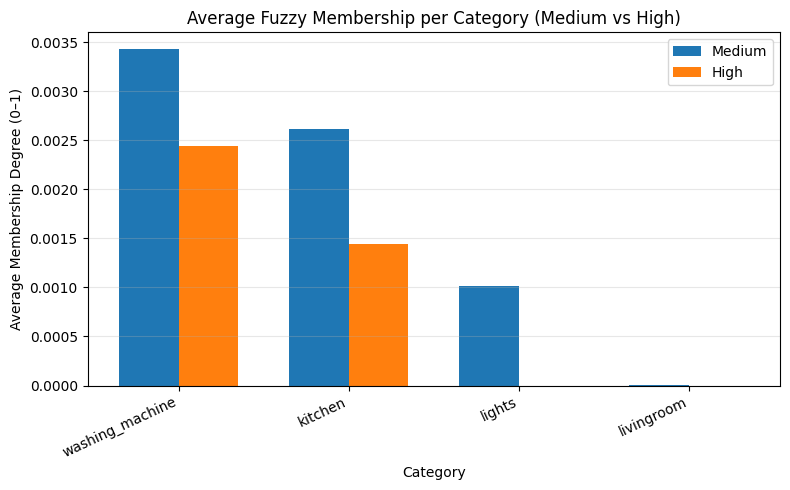

In [142]:
# Step 1: Get category mapping
categories = data.attrs["categories"]

# Step 2: Compute average fuzzy memberships per category
category_summary = {}

for cat, appliances in categories.items():
    med_cols = [f"{a}_medium" for a in appliances if f"{a}_medium" in fuzzy_data.columns]
    high_cols = [f"{a}_high" for a in appliances if f"{a}_high" in fuzzy_data.columns]

    if not med_cols and not high_cols:
        continue

    category_summary[cat] = {
        'Medium': fuzzy_data[med_cols].mean().mean() if med_cols else 0,
        'High': fuzzy_data[high_cols].mean().mean() if high_cols else 0
    }

# Step 3: Create DataFrame and sort
category_summary_df = pd.DataFrame(category_summary).T
category_summary_df['Total'] = category_summary_df['Medium'] + category_summary_df['High']
category_summary_df = category_summary_df.sort_values('Total', ascending=False)

# Step 4: Plot grouped bar chart
x = np.arange(len(category_summary_df))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, category_summary_df['Medium'], width, label='Medium')
ax.bar(x + width/2, category_summary_df['High'], width, label='High')

# Step 5: Style and labels
ax.set_xticks(x)
ax.set_xticklabels(category_summary_df.index, rotation=25, ha='right')
ax.set_ylabel("Average Membership Degree (0–1)")
ax.set_xlabel("Category")
ax.set_title("Average Fuzzy Membership per Category (Medium vs High)")
ax.legend()
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()


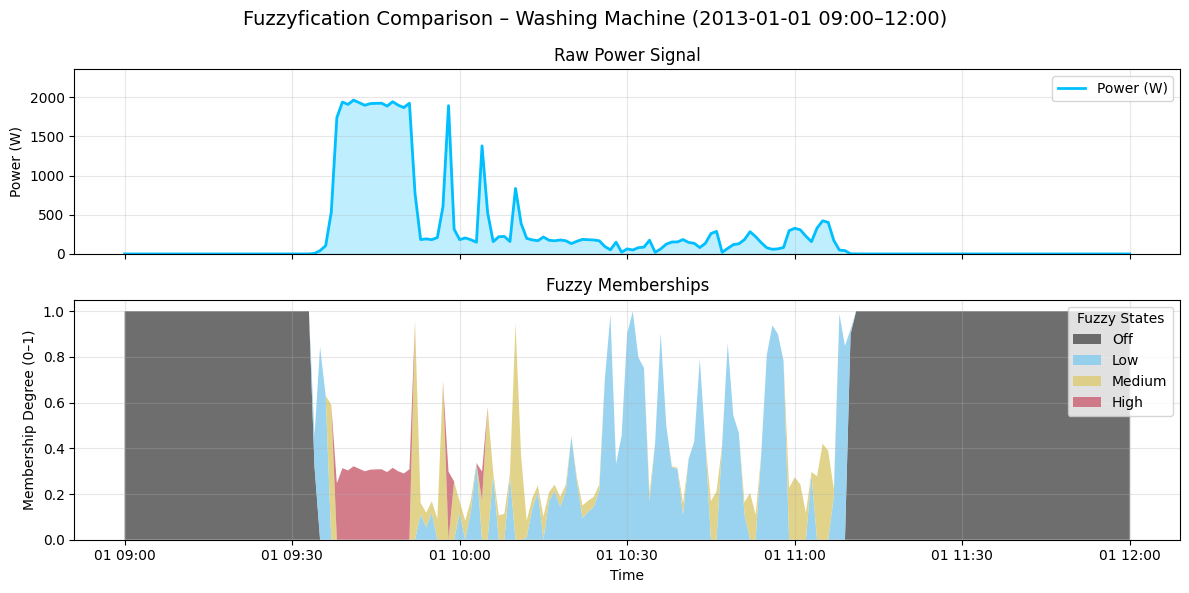

In [165]:
# Appliance + date range
appliance = "washing_machine"
start = pd.Timestamp("2013-01-01 09:00:00")
end   = pd.Timestamp("2013-01-01 12:00:00")

# Slice cleanly
raw = data.loc[(data.index >= start) & (data.index <= end), appliance]
fuzzy_subset = fuzzy_data.loc[(fuzzy_data.index >= start) & (fuzzy_data.index <= end), [
    f"{appliance}_off",
    f"{appliance}_low",
    f"{appliance}_medium",
    f"{appliance}_high"
]]

# --- Create Figure ---
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True,
                               gridspec_kw={'height_ratios': [1, 1.3]})
fig.suptitle(f"Fuzzyfication Comparison – {appliance.replace('_',' ').title()} ({start.date()} 09:00–12:00)",
             fontsize=14, y=0.98)

# --- 1️⃣ Raw Power Signal ---
ax1.plot(raw.index, raw.values, color='deepskyblue', linewidth=2, label="Power (W)")
ax1.fill_between(raw.index, 0, raw.values, color='deepskyblue', alpha=0.25)
ax1.set_ylabel("Power (W)")
ax1.set_ylim(0, raw.max() * 1.2)
ax1.set_title("Raw Power Signal")
ax1.legend(loc="upper right")
ax1.grid(alpha=0.3)

# --- 2️⃣ Fuzzy Memberships ---
colors = ["#555555", "#88CCEE", "#DDCC77", "#CC6677"]
labels = ["Off", "Low", "Medium", "High"]
ax2.stackplot(fuzzy_subset.index,
              fuzzy_subset.T.values,
              labels=labels, colors=colors, alpha=0.85)
ax2.set_ylabel("Membership Degree (0–1)")
ax2.set_xlabel("Time")
ax2.set_title("Fuzzy Memberships")
ax2.legend(title="Fuzzy States", loc='upper right', ncol=1)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()


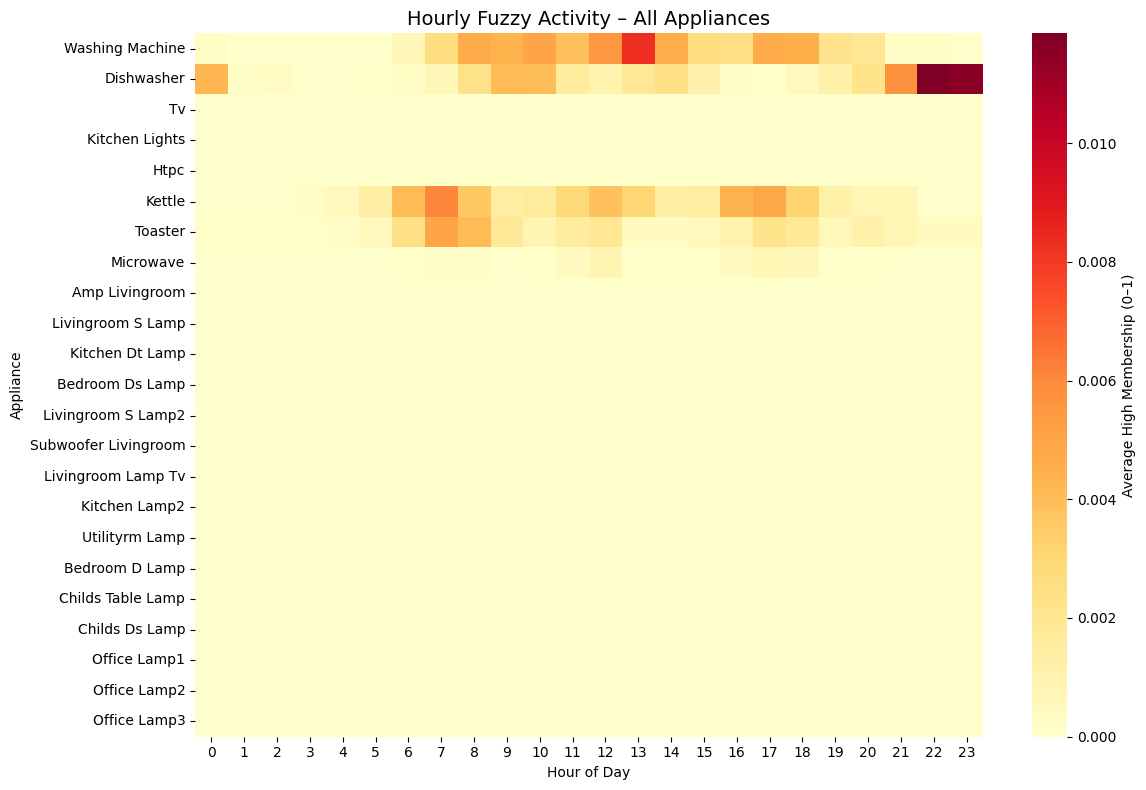

In [176]:
# --- Group by hour of day and average fuzzy "high" memberships ---
high_cols = [c for c in fuzzy_data.columns if c.endswith("_high")]

# Compute hourly means for each appliance
hourly_appliance = fuzzy_data[high_cols].groupby(fuzzy_data.index.hour).mean().T

# Clean labels
hourly_appliance.index = [c.replace("_high", "").replace("_", " ").title() for c in hourly_appliance.index]

# --- Plot ---
plt.figure(figsize=(12, 8))
sns.heatmap(hourly_appliance, cmap="YlOrRd", cbar_kws={"label": "Average High Membership (0–1)"})
plt.title("Hourly Fuzzy Activity – All Appliances", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Appliance")
plt.tight_layout()
plt.show()


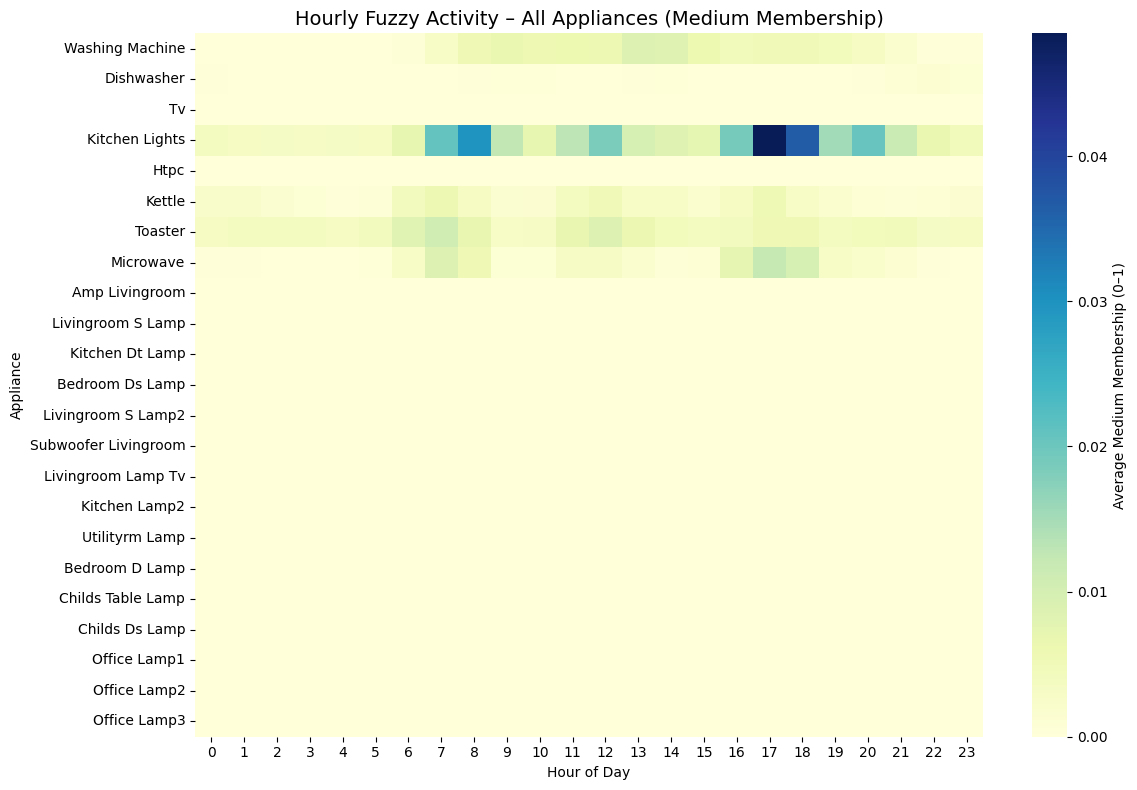

In [178]:
# --- Group by hour of day and average fuzzy "medium" memberships ---
med_cols = [c for c in fuzzy_data.columns if c.endswith("_medium")]

# Compute hourly means for each appliance
hourly_appliance_med = fuzzy_data[med_cols].groupby(fuzzy_data.index.hour).mean().T

# Clean labels
hourly_appliance_med.index = [c.replace("_medium", "").replace("_", " ").title() for c in hourly_appliance_med.index]

# --- Plot ---
plt.figure(figsize=(12, 8))
sns.heatmap(hourly_appliance_med, cmap="YlGnBu", cbar_kws={"label": "Average Medium Membership (0–1)"})
plt.title("Hourly Fuzzy Activity – All Appliances (Medium Membership)", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Appliance")
plt.tight_layout()
plt.show()


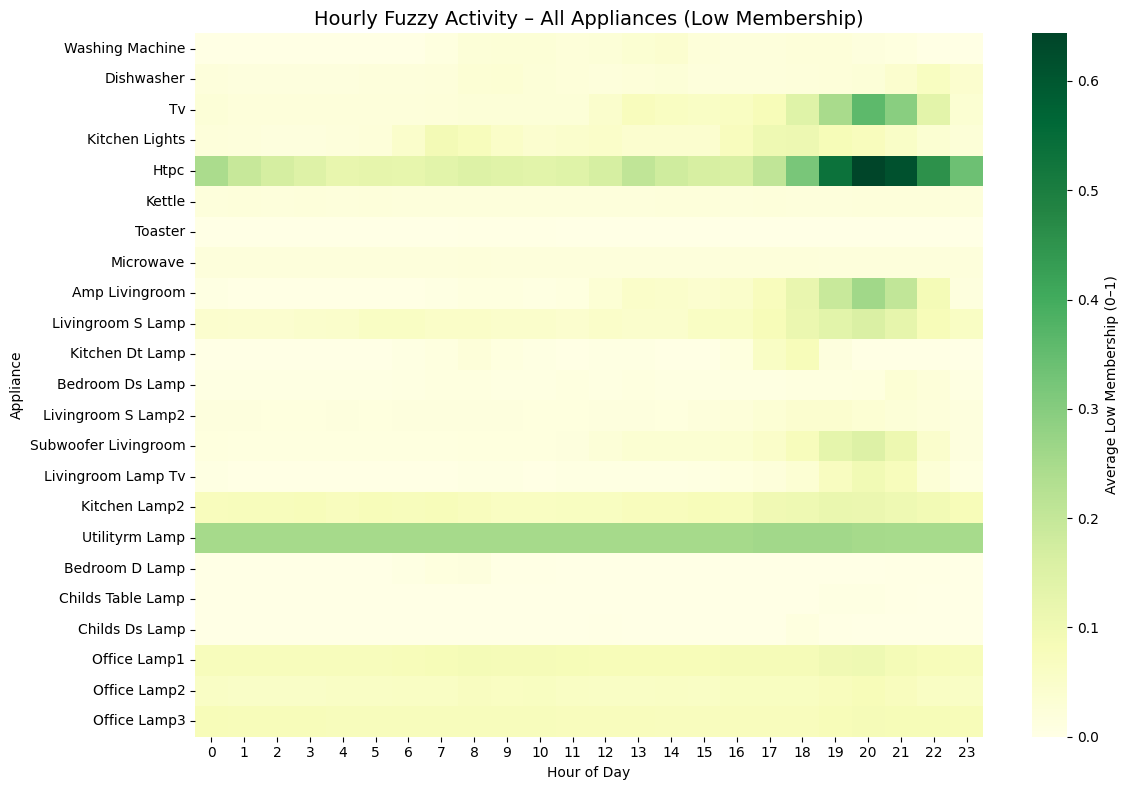

In [179]:
# --- Group by hour of day and average fuzzy "low" memberships ---
low_cols = [c for c in fuzzy_data.columns if c.endswith("_low")]

# Compute hourly means for each appliance
hourly_appliance_low = fuzzy_data[low_cols].groupby(fuzzy_data.index.hour).mean().T

# Clean labels
hourly_appliance_low.index = [c.replace("_low", "").replace("_", " ").title() for c in hourly_appliance_low.index]

# --- Plot ---
plt.figure(figsize=(12, 8))
sns.heatmap(hourly_appliance_low, cmap="YlGn", cbar_kws={"label": "Average Low Membership (0–1)"})
plt.title("Hourly Fuzzy Activity – All Appliances (Low Membership)", fontsize=14)
plt.xlabel("Hour of Day")
plt.ylabel("Appliance")
plt.tight_layout()
plt.show()